In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
from tqdm import tqdm
import optuna
import pickle

In [2]:
df = pd.read_csv("Crime_Incidents_20241007.csv")

In [3]:
df.shape

(314678, 31)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 314678 entries, 0 to 314677
Data columns (total 31 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   Case Number              314678 non-null  object 
 1   Incident Datetime        314678 non-null  object 
 2   Incident ID              0 non-null       float64
 3   Incident Type Primary    314678 non-null  object 
 4   Incident Description     314678 non-null  object 
 5   Parent Incident Type     314678 non-null  object 
 6   Hour of Day              314678 non-null  int64  
 7   Day of Week              314678 non-null  object 
 8   Address                  314640 non-null  object 
 9   City                     314678 non-null  object 
 10  State                    314678 non-null  object 
 11  Location                 308426 non-null  object 
 12  Latitude                 313705 non-null  object 
 13  Longitude                313705 non-null  object 
 14  Crea

In [5]:
# dropping completely null columns
df.drop(columns=["Incident ID","updated_at"],inplace=True)

In [6]:
df.head()

,Case Number,Incident Datetime,Incident Type Primary,Incident Description,Parent Incident Type,Hour of Day,Day of Week,Address,City,State,...,Census Block Group,Census Block,2010 Census Tract,2010 Census Block Group,2010 Census Block,Police District,TRACTCE20,GEOID20_tract,GEOID20_blockgroup,GEOID20_block
0,16-1660403,06/14/2016 01:20:00 AM,ASSAULT,ASSAULT,Assault,1,Tuesday,E AMHERST ST & E AMHERST ST,Buffalo,NY,...,2,2003,55,2,2005,District D,005500,36029005500,360290001102,360290170002003
1,16-3480266,12/13/2016 05:00:00 AM,LARCENY/THEFT,LARCENY/THEFT,Theft,5,Tuesday,1000 Block E LOVEJOY ST,Buffalo,NY,...,4,4001,23,4,4001,District C,002300,36029002300,360290002004,360290034004001
2,20-2010167,07/19/2020 03:09:00 AM,ASSAULT,Buffalo Police are investigating this report o...,Assault,3,Sunday,GRIDER ST & KENSINGTON WB,Buffalo,NY,...,NaN,NaN,NaN,NaN,NaN,NaN,UNKNOWN,UNKNOWN,UNKNOWN,UNKNOWN
3,14-3210732,11/17/2014 08:08:00 AM,LARCENY/THEFT,LARCENY/THEFT,Theft,8,Monday,2100 Block ELMWOOD AV,Buffalo,NY,...,2,2007,56,2,2008,District D,005600,36029005600,360290001102,360290163002007
4,15-1100268,04/20/2015 10:22:00 AM,LARCENY/THEFT,LARCENY/THEFT,Theft,10,Monday,2100 Block ELMWOOD AV,Buffalo,NY,...,2,2007,56,2,2008,District D,005600,36029005600,360290001102,360290163002007


In [7]:
print(df.isna().sum())

Case Number                     0
Incident Datetime               0
Incident Type Primary           0
Incident Description            0
Parent Incident Type            0
Hour of Day                     0
Day of Week                     0
Address                        38
City                            0
State                           0
Location                     6252
Latitude                      973
Longitude                     973
Created At                 244064
zip_code                     2357
neighborhood                 3321
Council District             2408
Council District 2011        2357
Census Tract                 3321
Census Block Group           3321
Census Block                 3321
2010 Census Tract            3321
2010 Census Block Group      3321
2010 Census Block            3321
Police District              3321
TRACTCE20                    3184
GEOID20_tract                3184
GEOID20_blockgroup           3184
GEOID20_block                3184
dtype: int64


In [8]:
# dropping created_at , as it has no relation
df.drop(columns=["Created At"],inplace=True)

# since outliers are less in number , removing all
df.dropna(inplace=True)

In [9]:
# splitting time to day , month and year
def SplitMonth(data):
    array = data.split("/")
    if len(array) < 3:
        return 0
    array[:] = array[:2]+[array[2].split(" ")[0]]
    return int(array[0])

def SplitDay(data):
    array = data.split("/")
    if len(array) < 3:
        return 0
    array[:] = array[:2]+[array[2].split(" ")[0]]
    return int(array[1])

def SplitYear(data):
    array = data.split("/")
    if len(array) < 3:
        return 0
    array[:] = array[:2]+[array[2].split(" ")[0]]
    return int(array[2])


df['Month'] = df["Incident Datetime"].apply(lambda x: SplitMonth(x))
df['Day'] = df["Incident Datetime"].apply(lambda x: SplitDay(x))
df['Year'] = df["Incident Datetime"].apply(lambda x: SplitYear(x))

# dropping time 
df.drop(columns=["Incident Datetime"],inplace=True)

In [10]:
df.nunique()

Case Number                308338
Incident Type Primary          21
Incident Description           14
Parent Incident Type            9
Hour of Day                    24
Day of Week                     7
Address                     21162
City                            1
State                           1
Location                     8659
Latitude                      150
Longitude                     122
zip_code                       21
neighborhood                   36
Council District               10
Council District 2011          11
Census Tract                   92
Census Block Group              8
Census Block                  243
2010 Census Tract              80
2010 Census Block Group         8
2010 Census Block             289
Police District                 6
TRACTCE20                      92
GEOID20_tract                  92
GEOID20_blockgroup            291
GEOID20_block                2771
Month                          12
Day                            31
Year          

In [11]:
# dropping columns with a single value
df.drop(columns=["State","City"],inplace=True)

In [12]:
# converting dataType-object to numerical

def FixCasing(number):
    digitStripped = [i for i in number if i.isdigit()]
    final = ""
    if len(digitStripped) > 0:
        for i in digitStripped:
            final += i
        return float(final)
    return 0

df['Case Number'] = df['Case Number'].apply(lambda x : float(FixCasing(x)))
df['zip_code'] = df['zip_code'].apply(lambda x: float(FixCasing(x)))
df['Longitude'] = df['Longitude'].apply(lambda x: float(x))
df['Latitude'] = df['Latitude'].apply(lambda x: float(x))



In [13]:
# removing invalid entries and setting to lower
for c in ['Census Tract','2010 Census Block','2010 Census Block Group','2010 Census Tract ',
          'Census Block Group','Census Block','TRACTCE20','GEOID20_tract','GEOID20_blockgroup',
          'GEOID20_block']:
    df = df[df[c] != 'UNKNOWN']
    df[c] = df[c].apply(lambda x: float(x))

In [14]:
# removing 'UNKNOWN' from df
for cols in df.columns:
    df = df[df[cols] != 'UNKNOWN']

In [15]:
print(df.select_dtypes('object').columns)

Index(['Incident Type Primary', 'Incident Description', 'Parent Incident Type',
       'Day of Week', 'Address', 'Location', 'neighborhood',
       'Council District', 'Council District 2011', 'Police District'],
      dtype='object')


In [16]:
df.nunique()

Case Number                293309
Incident Type Primary          21
Incident Description           14
Parent Incident Type            9
Hour of Day                    24
Day of Week                     7
Address                     20765
Location                     8506
Latitude                      137
Longitude                     112
zip_code                       21
neighborhood                   35
Council District               10
Council District 2011          10
Census Tract                   91
Census Block Group              7
Census Block                  240
2010 Census Tract              79
2010 Census Block Group         7
2010 Census Block             288
Police District                 5
TRACTCE20                      91
GEOID20_tract                  91
GEOID20_blockgroup            290
GEOID20_block                2689
Month                          12
Day                            31
Year                           58
dtype: int64

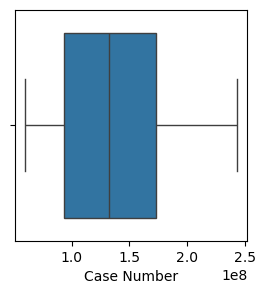

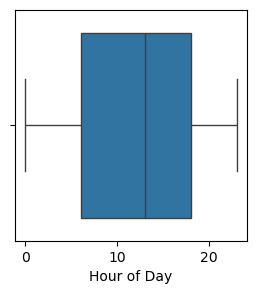

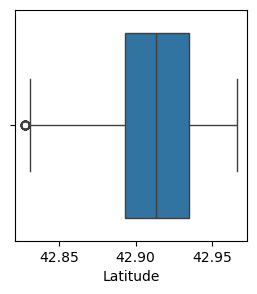

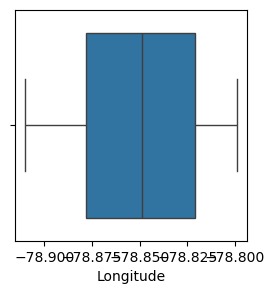

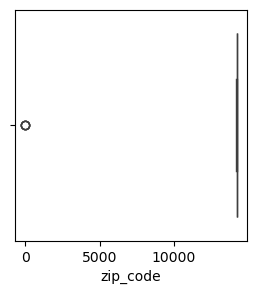

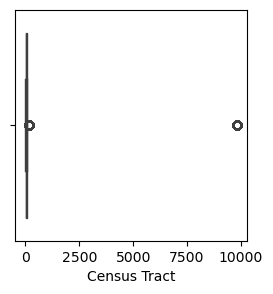

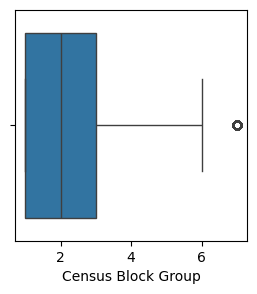

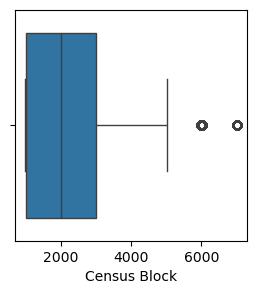

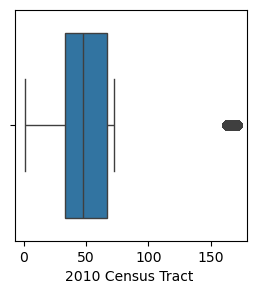

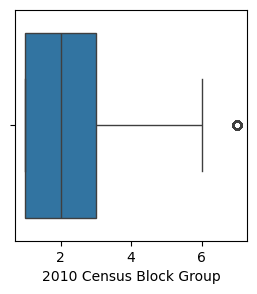

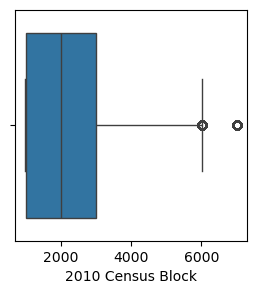

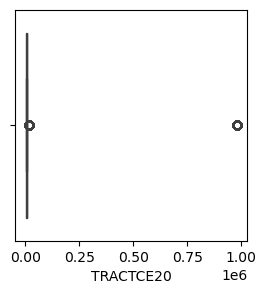

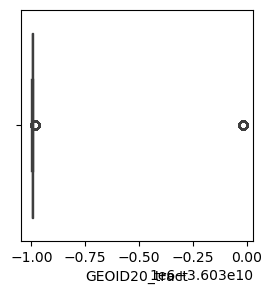

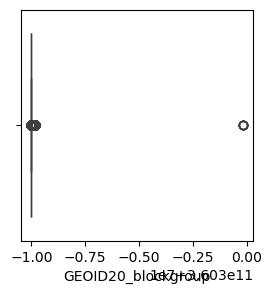

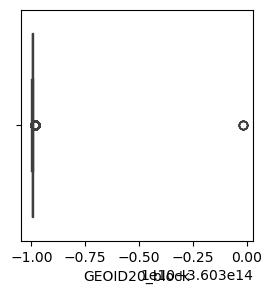

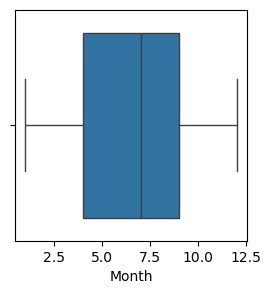

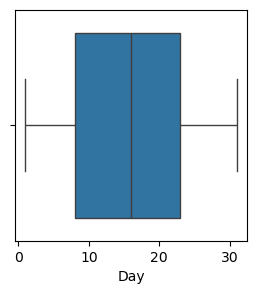

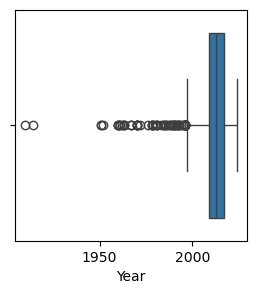

In [17]:
# check for outliers
for col in df.select_dtypes(["int64",'float64']).columns:
    plt.figure(figsize=(3, 3))
    sns.boxplot(x=df[col])  
    plt.show()

In [18]:
for c in df.select_dtypes(include=['int64','float64']).columns:
    Q1 = df[c].quantile(0.25)
    Q3 = df[c].quantile(0.75)
    IQR = Q3 - Q1

    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = df[(df[c] < lower_bound) | (df[c] > upper_bound)]

    print(f"{c:10} : {len(outliers):1}")

Case Number : 0
Hour of Day : 0
Latitude   : 25
Longitude  : 0
zip_code   : 4
Census Tract : 45054
Census Block Group : 632
Census Block : 2684
2010 Census Tract  : 44767
2010 Census Block Group : 632
2010 Census Block : 1506
TRACTCE20  : 45054
GEOID20_tract : 45054
GEOID20_blockgroup : 72110
GEOID20_block : 63685
Month      : 0
Day        : 0
Year       : 65


In [19]:
df['2010 Census Block Group'].value_counts()

2010 Census Block Group
1.0    93110
2.0    70593
3.0    64742
4.0    45544
5.0    15961
6.0     2727
7.0      632
Name: count, dtype: int64

In [20]:
# Target -  2010 Census Block Group

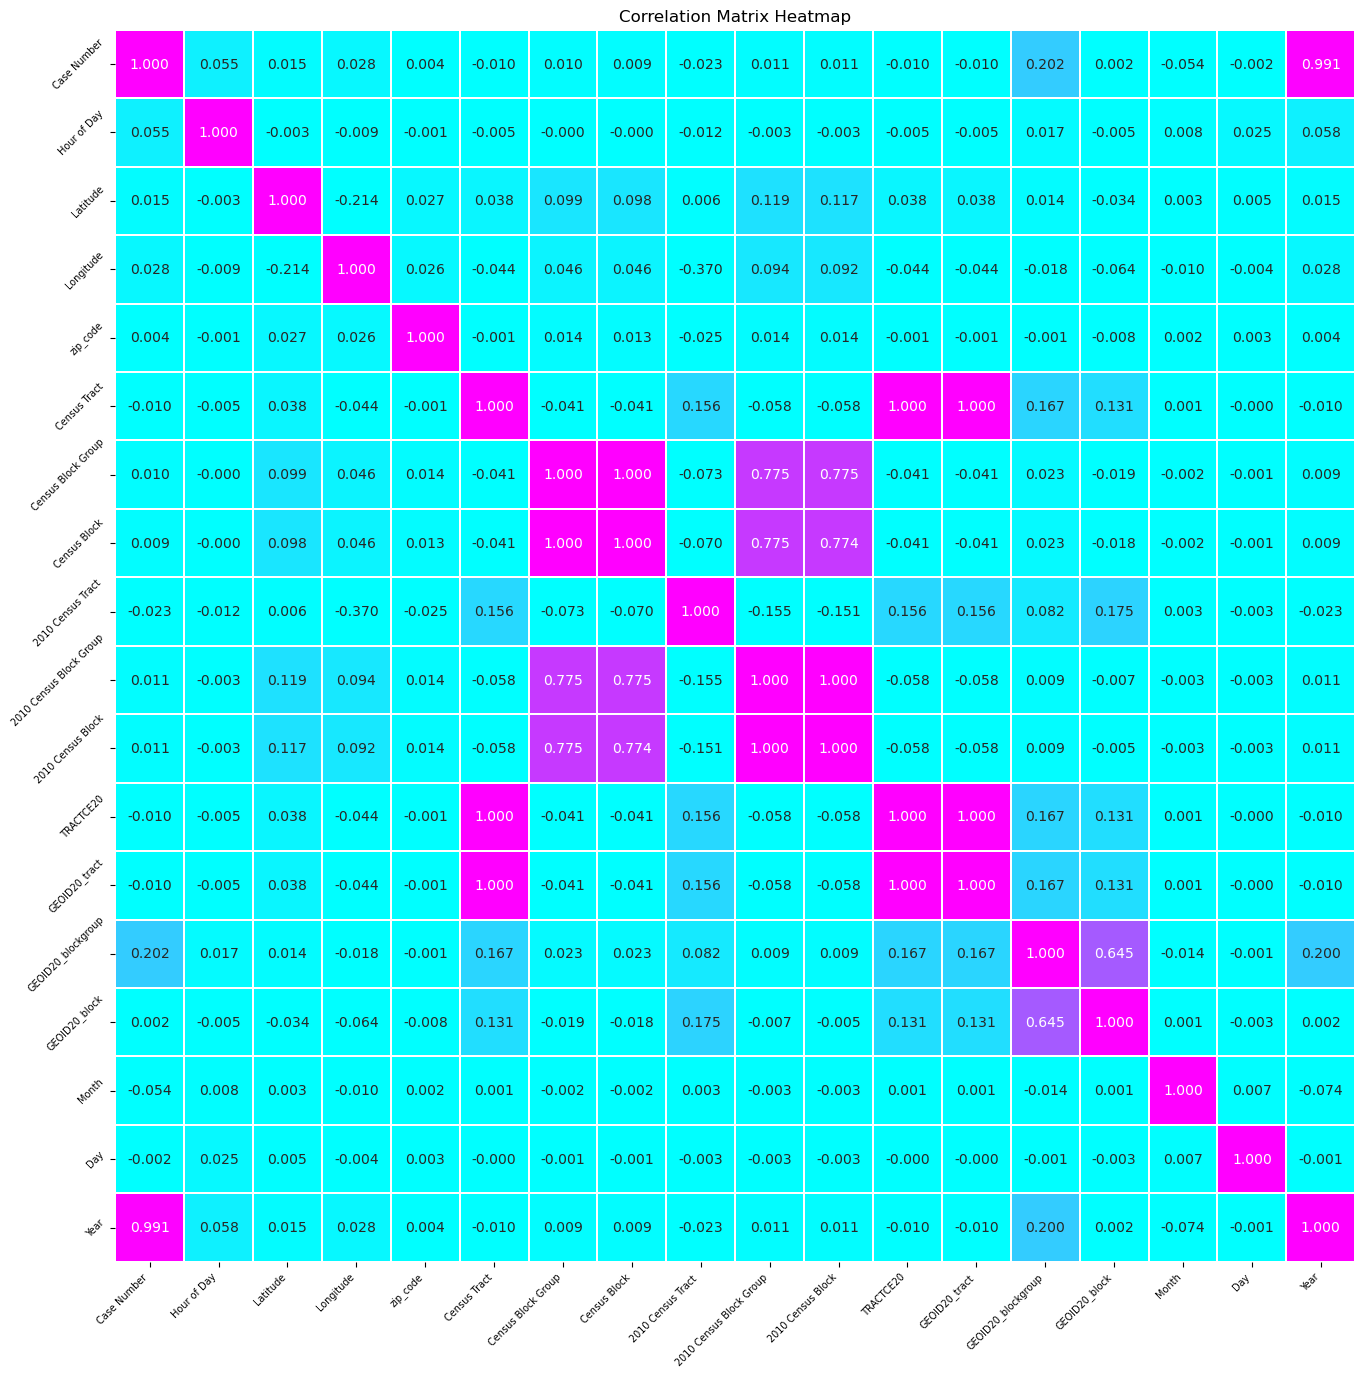

In [21]:
correlation_matrix = df.select_dtypes(include=['int64','float64']).corr()


plt.figure(figsize=(16, 16))

sns.heatmap(correlation_matrix, annot=True, cmap='cool', vmin=0, vmax=1, linewidths=0.1, fmt='.3f' , cbar=False)    
plt.xticks(rotation=45, ha='right',fontsize=7) 
plt.yticks(rotation=45, ha='right',fontsize=7)
plt.title('Correlation Matrix Heatmap')
plt.show()

In [22]:
# dropping duplicate/redundant columns and very low-correlation to target
df.drop(columns=['Hour of Day','Day','Month','GEOID20_block','GEOID20_blockgroup'],inplace=True)

In [23]:
# for c in ['Latitude','Census Block Group','2010 Census Block Group']:
for c in df.select_dtypes(include=['int64','float64']).columns:
    Q1 = df[c].quantile(0.25)
    Q3 = df[c].quantile(0.75)
    IQR = Q3 - Q1

    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = df[(df[c] < lower_bound) | (df[c] > upper_bound)]

    print(f"{c:10} : {len(outliers):1}")
    if len(outliers) > 0.2*(len(df)):
        # replace with mean
        mean = df.mean()
        df.loc[(df[c] < lower_bound) | (df[c] > upper_bound),c] = mean
    else:
        # removing outliers 
        df = df[(df[c] >= lower_bound) & (df[c] <= upper_bound)]

Case Number : 0
Latitude   : 25
Longitude  : 0
zip_code   : 4
Census Tract : 45054
Census Block Group : 632
Census Block : 1387
2010 Census Tract  : 88
2010 Census Block Group : 0
2010 Census Block : 97
TRACTCE20  : 0
GEOID20_tract : 0
Year       : 52


In [24]:
# Address and Location can be frequency encoded rest all can be one-hot encoded
for col in ["Address","Location"]:
    frequency = df[col].value_counts()
    df[col] = df[col].map(frequency)

for c in df.select_dtypes('object'):
    df = pd.get_dummies(df, columns=[c],dtype=float) 



In [25]:
X = df.drop(columns=["2010 Census Block Group"])
Y = df["2010 Census Block Group"]
splitRatio = int(len(X)*0.8)
X_train ,X_test= X[:splitRatio] , X[splitRatio:]
y_train , y_test = Y[:splitRatio], Y[splitRatio:]

print(X_train.shape,X_test.shape,y_train.shape,y_test.shape)

(196776, 124) (49194, 124) (196776,) (49194,)


In [26]:
class RidgeRegression():
    def __init__(self,lambd) -> None:
        self.lambd = lambd
    def fit(self,X, y):
        XTX = np.dot(X.T,X)
        identity_matrix = np.eye(X.shape[1])
        INV = np.linalg.inv(XTX + self.lambd * identity_matrix)
        DOT =  np.dot(INV, X.T)
        final = np.dot(DOT,y)
        return final
    def Predict(self,w,X):
        return np.dot(X,w)
    def MSE(self,y_actuals,y_pred):
        return np.mean((y_actuals-y_pred)**2)

In [27]:
model = RidgeRegression(lambd=0.1)
w = model.fit(X_train, y_train)
y_pred = model.Predict(w,X_test)


mse = model.MSE(y_test, y_pred)
print(f"Ridge Regression MSE: {mse:0.7f}")


Ridge Regression MSE: 0.0000073


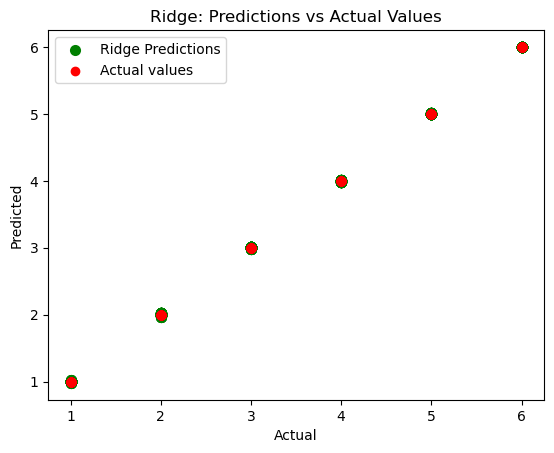

In [28]:
plt.scatter(y_test, y_pred, color='green', label='Ridge Predictions', linewidth=2)
plt.scatter(y_test, y_test, color='red', label='Actual values', linewidth=1)
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Ridge: Predictions vs Actual Values')
plt.legend()
plt.show()

In [29]:
def objective(trial):
    lambda_value = trial.suggest_loguniform('alpha', 0.00001, 100) 
    model = RidgeRegression(lambda_value)
    w = model.fit(X_train, y_train)
    y_pred = model.Predict(w,X_test)
    mse = model.MSE(y_test, y_pred)
    return mse

In [30]:
optuna.logging.disable_default_handler()
study = optuna.create_study(direction='minimize')

study.optimize(objective, n_trials=1000)

print("Best hyperparameters: ", study.best_params)
print("Best mean squared error: ", study.best_value)


Best hyperparameters:  {'alpha': 0.024681144335779285}
Best mean squared error:  7.271871682656586e-06


In [31]:
model = RidgeRegression(lambd=study.best_params['alpha'])
model.fit(X_train, y_train)
with open('Nikhil_Gishnu_assignment1_bonus.pickle', 'wb') as file:
    pickle.dump(model, file)

print("Model saved successfully!")

Model saved successfully!
